In [45]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns; sns.set_theme()
import warnings
from matplotlib.ticker import PercentFormatter
warnings.filterwarnings("ignore")

## Load CSV

In [46]:
dataFrame = pd.read_table(r"./Data/FDAXM22-EUREX 5Min.csv", sep = ";", engine = 'python')
for col in dataFrame.columns:
    if col[0] == " ":
        dataFrame = dataFrame.rename(columns={col : col[1:]})

In [47]:
dataFrame_IB = pd.read_table("Data/dataIB.csv", sep = ";", engine = 'python')

In [48]:
dataFrame_daily = pd.read_table(r"./Data/DailyData_VolumeProfile.csv", sep = ";", engine = 'python')

In [49]:
dataFrame_norm = pd.read_table("Data/dataNormalisee(14).csv", sep = ";", engine = 'python')

In [50]:
dataFrame_norm_daily = pd.read_table("Data/dataNormalisee_daily(14).csv", sep = ";", engine = 'python')

In [51]:
dataFrame_norm_IB = pd.read_table("Data/dataNormalisee_IB(14).csv", sep = ";", engine = 'python')

In [52]:
dataFrame_results_ZScore = pd.read_table(r'ZScoresCalcules.csv', sep = ";", engine = 'python')

In [53]:
dataFrame_results_ZScore_5min = pd.read_table(r'ZScoresCalcules5min.csv', sep = ";", engine = 'python')

## Load Data

In [54]:
def load_data(df):
    spread = np.array(df.High - df.Low)
    meanSpread = np.mean(spread)
    sigmaSpread = np.std(spread)
    
    volume = np.array(df.Volume)
    meanVolume = np.mean(volume)
    sigmaVolume = np.std(volume)
    
    return spread, meanSpread, sigmaSpread, volume, meanVolume, sigmaVolume

#### Data non normalisée

In [55]:
spread, meanSpread, sigmaSpread, volume, meanVolume, sigmaVolume = load_data(dataFrame)

In [56]:
spread_daily, meanSpread_daily, sigmaSpread_daily, volume_daily, meanVolume_daily, sigmaVolume_daily = load_data(dataFrame_daily)

In [57]:
spread_IB, meanSpread_IB, sigmaSpread_IB, volume_IB, meanVolume_IB, sigmaVolume_IB = load_data(dataFrame_IB)

#### Data normalisée

In [58]:
spread_norm, meanSpread_norm, sigmaSpread_norm, volume_norm, meanVolume_norm, sigmaVolume_norm = load_data(dataFrame_norm)

In [59]:
spread_daily_norm, meanSpread_daily_norm, sigmaSpread_daily_norm, volume_daily_norm, meanVolume_daily_norm, sigmaVolume_daily_norm = load_data(dataFrame_norm_daily)

In [60]:
spread_IB_norm, meanSpread_IB_norm, sigmaSpread_IB_norm, volume_IB_norm, meanVolume_IB_norm, sigmaVolume_IB_norm = load_data(dataFrame_norm_IB)

## Visualize Data 

In [61]:
print('mean Spread = ' + str(round(meanSpread, 2)) + ", standard deviation Spread = " + str(round(sigmaSpread, 2)))
print('mean Volume = ' + str(round(meanVolume, 2)) + ", standard deviation Volume = " + str(round(sigmaVolume, 2)))

mean Spread = 12.01, standard deviation Spread = 10.27
mean Volume = 537.42, standard deviation Volume = 536.11


In [62]:
def f(x, mean, sigma):
    return 1/((2*np.pi*sigma**2)**0.5)*np.exp(-0.5*((x-mean)/sigma)**2)

In [63]:
def copyArray(array):
    try:
        size = len(array[0])
        new_array = []
        for i in range(size):
            new_line = [0]*len(array[i])
            for j in range(len(array[i])):
                new_line[j] = array[i][j]
            new_array.append(new_line)
        return new_array
    except (IndexError, TypeError):
        new_array = [0]*len(array)
        for i in range(len(array)):
            new_array[i] = array[i]
        return new_array

In [64]:
sorted_spread = copyArray(spread)
sorted_spread.sort()

# Density Estimation

## Optimal Bandwidth

In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

In [68]:
def find_optimal_bandwidth_kernel(donnees, kernel):
    params = {"bandwidth": np.arange(0.001, 2, 0.1)}
        
    data = donnees.reshape(-1, 1)
    grid = GridSearchCV(KernelDensity(kernel=kernel), params)
    grid.fit(data)
    
    print("kernel: " + str(kernel) + " -> best bandwidth: " + str(grid.best_estimator_.bandwidth) + " / Best score: " + str(grid.best_score_))
    return grid, grid.best_score_

In [69]:
def find_optimal_bandwidth(donnees):
    print("Cross-validation\n")
    
    kernels = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
    best_accuracy = float('-inf')
    best_estimator = None
    for kernel in kernels:
        grid, accuracy = find_optimal_bandwidth_kernel(donnees, kernel)
        if accuracy >= best_accuracy:
            best_accuracy = accuracy
            best_estimator = grid.best_estimator_
        
    print("\nBest estimator: ", end='')
    print(best_estimator)
    print()
    return best_estimator

## Kernel Density Estimator

In [70]:
def equals(l, l2):
    if len(l) != len(l2):
        return False
    for i in range(len(l)):
        if l[i] != l2[i]:
            return False
    return True

In [72]:
def find_data_title(data):
    if equals(data, spread):
        parameter = "spread"
    elif equals(data, spread_daily):
        parameter = "spread daily"
    elif equals(data, spread_IB):
        parameter = "spread IB"
    elif equals(data, volume):
        parameter = "volume"
    elif equals(data, volume_daily):
        parameter = "volume daily"
    elif equals(data, volume_IB):
        parameter = "volume IB"
        
    if equals(data, spread_norm):
        parameter = "spread normalisé"
    elif equals(data, spread_daily_norm):
        parameter = "spread daily normalisé"
    elif equals(data, spread_IB_norm):
        parameter = "spread IB normalisé"
    elif equals(data, volume_norm):
        parameter = "volume normalisé"
    elif equals(data, volume_daily_norm):
        parameter = "volume daily normalisé"
    elif equals(data, volume_IB_norm):
        parameter = "volume IB normalisé"
        
    return parameter

In [73]:
def fit_estimator(data, model):
    parameter = find_data_title(data)

    # fit density
    
    sample = np.array(data).reshape((len(data), 1))
    model.fit(sample)
    
    kernel = model.get_params()['kernel']
    
    # sample probabilities for a range of outcomes
    #values = np.array(range(0, math.ceil(np.max(data))))
    values = np.array(np.arange(np.min(data), np.max(data), 0.00001))
    values = values.reshape((len(values), 1))
    probabilities = model.score_samples(values)
    probabilities = np.exp(probabilities)
    # plot the histogram and pdf
    plt.figure(figsize=(12,8))
    plt.hist(sample, bins=100, density=True, label='Histogramme des valeurs du ' + parameter)
    plt.plot(values, probabilities, label='Densité estimée', c = 'r', linewidth = 3)
    plt.legend(loc = 'best')
    plt.title('Estimation de la densité - variable ' + parameter + "\n Kernel : " + kernel + "\n", fontsize = 16)
    plt.xlabel('Valeurs du ' + parameter)
    plt.ylabel("Probabilité d'apparition\n")
    plt.xlim([np.min(data), np.max(data)])
    #plt.ylim([0, 90])
    plt.show()
    
    return model

In [74]:
import time
import tensorflow as tf
tf.debugging.set_log_device_placement(True)

def estimate_density(data):
    with tf.device('/device:GPU:0'):
        start = time.time()

        optimal_model = find_optimal_bandwidth(data)
        estimator = fit_estimator(data, optimal_model)

        stop = time.time()
        total = round(stop - start, 2)
        print("temps total : " + str(total) + " s")
        return estimator

## Estimate Densities for all variables

### Non normalisé

#### Daily et Initial Balance

Cross-validation

kernel: gaussian -> best bandwidth: 21.400000000000002 / Accuracy: -2749.0671937598745
kernel: tophat -> best bandwidth: 84.60000000000001 / Accuracy: -2772.776592245076
kernel: epanechnikov -> best bandwidth: 85.2 / Accuracy: -2759.953101026023
kernel: exponential -> best bandwidth: 12.9 / Accuracy: -2747.420321820591
kernel: linear -> best bandwidth: 85.30000000000001 / Accuracy: -2756.480739915811
kernel: cosine -> best bandwidth: 85.2 / Accuracy: -2758.8810101931485

Best estimator: KernelDensity(bandwidth=12.9, kernel='exponential')



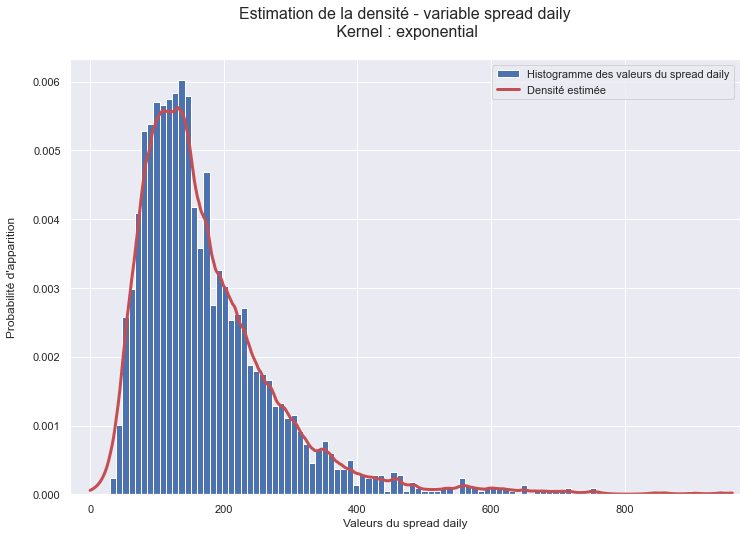

In [93]:
estim_spread_daily = estimate_density(spread_daily)

Cross-validation

kernel: gaussian -> best bandwidth: 10.600000000000001 / Accuracy: -2150.948068380599
kernel: tophat -> best bandwidth: 0.1 / Accuracy: -inf
kernel: epanechnikov -> best bandwidth: 0.1 / Accuracy: -inf
kernel: exponential -> best bandwidth: 4.9 / Accuracy: -2128.6646868255275
kernel: linear -> best bandwidth: 0.1 / Accuracy: -inf
kernel: cosine -> best bandwidth: 0.1 / Accuracy: -inf

Best estimator: KernelDensity(bandwidth=4.9, kernel='exponential')



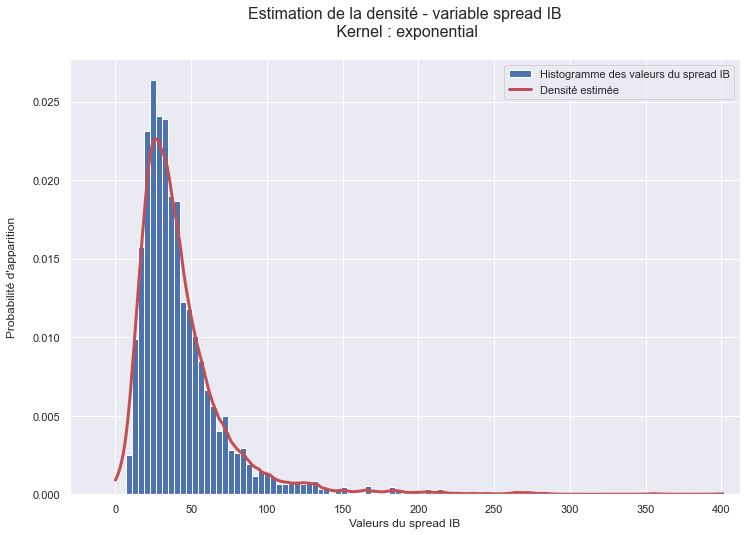

In [94]:
estim_spread_IB = estimate_density(spread_IB)

Cross-validation

kernel: gaussian -> best bandwidth: 4999.5 / Accuracy: -5511.365801570115
kernel: tophat -> best bandwidth: 100.0 / Accuracy: -inf
kernel: epanechnikov -> best bandwidth: 100.0 / Accuracy: -inf
kernel: exponential -> best bandwidth: 4999.5 / Accuracy: -5509.199454265563
kernel: linear -> best bandwidth: 100.0 / Accuracy: -inf
kernel: cosine -> best bandwidth: 100.0 / Accuracy: -inf

Best estimator: KernelDensity(bandwidth=4999.5, kernel='exponential')



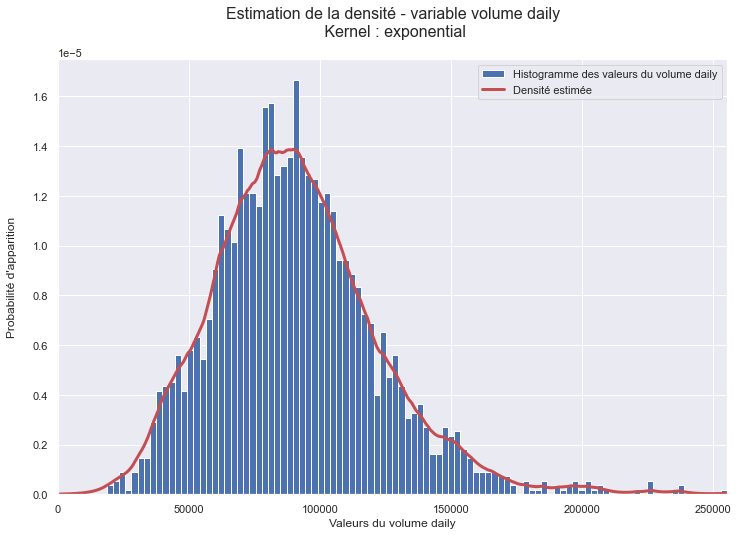

In [95]:
estim_volume_daily = estimate_density(volume_daily)

Cross-validation

kernel: gaussian -> best bandwidth: 1171.5 / Accuracy: -4287.659730757427
kernel: tophat -> best bandwidth: 100.0 / Accuracy: -inf
kernel: epanechnikov -> best bandwidth: 100.0 / Accuracy: -inf
kernel: exponential -> best bandwidth: 597.0 / Accuracy: -4271.178289243736
kernel: linear -> best bandwidth: 100.0 / Accuracy: -inf
kernel: cosine -> best bandwidth: 100.0 / Accuracy: -inf

Best estimator: KernelDensity(bandwidth=597.0, kernel='exponential')



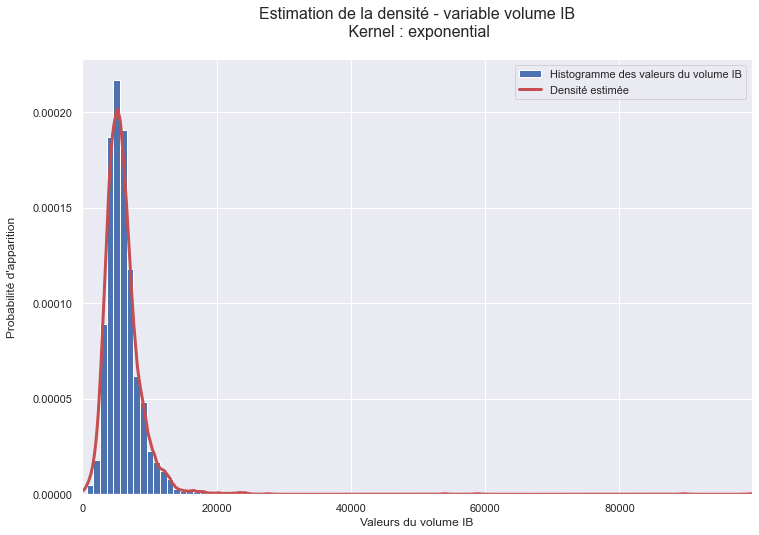

In [96]:
estim_volume_IB = estimate_density(volume_IB)

#### 5 minutes

In [ ]:
estim_spread = estimate_density(spread)

Cross-validation



In [ ]:
estim_volume = estimate_density(volume)

###  Normalisé

#### Daily et Initial Balance

Cross-validation

kernel: gaussian -> best bandwidth: 0.003 / Best score: 1683.7742753979098
kernel: tophat -> best bandwidth: 0.014000000000000002 / Best score: 1566.7794578340709
kernel: epanechnikov -> best bandwidth: 0.014000000000000002 / Best score: 1628.4396446908777
kernel: exponential -> best bandwidth: 0.002 / Best score: 1686.910026710587
kernel: linear -> best bandwidth: 0.014000000000000002 / Best score: 1644.8868171492904
kernel: cosine -> best bandwidth: 0.014000000000000002 / Best score: 1633.3175380027278

Best estimator: KernelDensity(bandwidth=0.002, kernel='exponential')



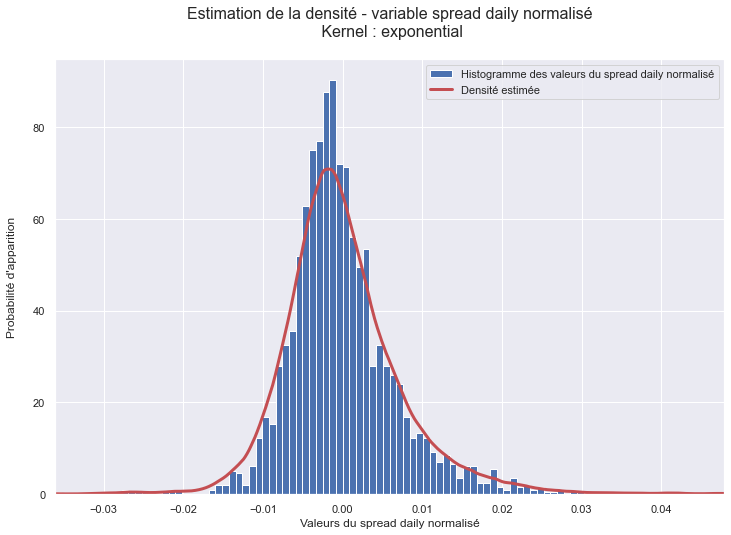

temps total : 2817.19 s


In [132]:
estim_spread_daily_norm = estimate_density(spread_daily_norm)

Cross-validation

kernel: gaussian -> best bandwidth: 0.001 / Best score: 2238.158914635757
kernel: tophat -> best bandwidth: 0.009000000000000001 / Best score: 1855.7421477959456
kernel: epanechnikov -> best bandwidth: 0.009000000000000001 / Best score: 1995.5435769655403
kernel: exponential -> best bandwidth: 0.001 / Best score: 2249.6050545155585
kernel: linear -> best bandwidth: 0.009000000000000001 / Best score: 2050.57471183595
kernel: cosine -> best bandwidth: 0.009000000000000001 / Best score: 2009.1927691393987

Best estimator: KernelDensity(bandwidth=0.001, kernel='exponential')



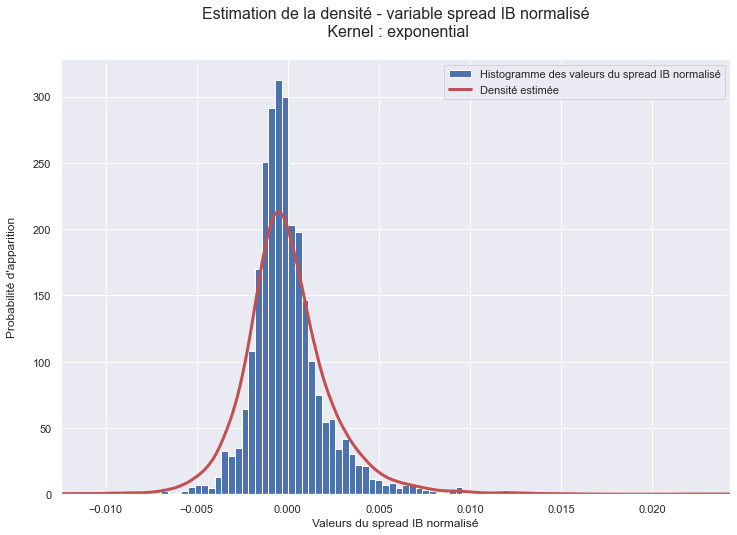

temps total : 2678.33 s


In [133]:
estim_spread_IB_norm = estimate_density(spread_IB_norm)

Cross-validation

kernel: gaussian -> best bandwidth: 0.07100000000000001 / Best score: -31.993849254096205
kernel: tophat -> best bandwidth: 0.246 / Best score: -41.380434289792376
kernel: epanechnikov -> best bandwidth: 0.25 / Best score: -35.45764017435387
kernel: exponential -> best bandwidth: 0.045 / Best score: -31.63605081739313
kernel: linear -> best bandwidth: 0.251 / Best score: -34.17617044231599
kernel: cosine -> best bandwidth: 0.25 / Best score: -35.0422974645298

Best estimator: KernelDensity(bandwidth=0.045, kernel='exponential')



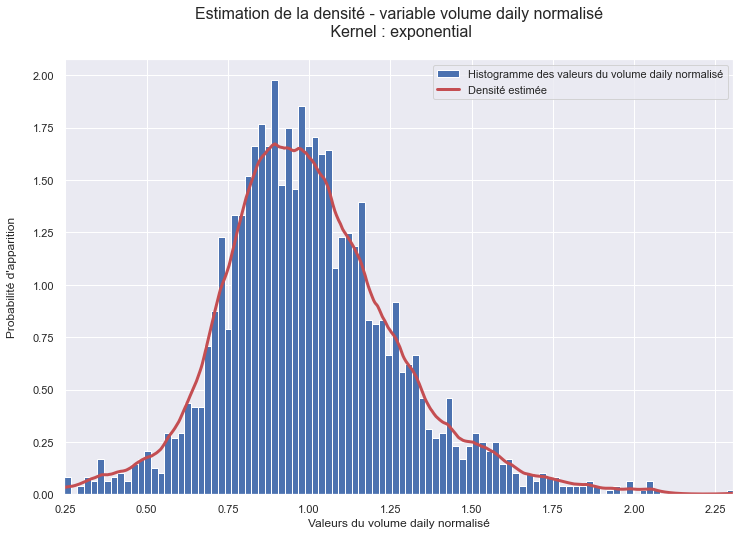

temps total : 2800.1 s


In [149]:
estim_volume_daily_norm = estimate_density(volume_daily_norm)

Cross-validation

kernel: gaussian -> best bandwidth: 0.075 / Best score: -108.73850869220632
kernel: tophat -> best bandwidth: 0.28500000000000003 / Best score: -122.23560703130838
kernel: epanechnikov -> best bandwidth: 0.28700000000000003 / Best score: -114.25008748126531
kernel: exponential -> best bandwidth: 0.051000000000000004 / Best score: -108.43373578306151
kernel: linear -> best bandwidth: 0.28800000000000003 / Best score: -112.3486218515973
kernel: cosine -> best bandwidth: 0.28800000000000003 / Best score: -113.64722650821118

Best estimator: KernelDensity(bandwidth=0.051000000000000004, kernel='exponential')



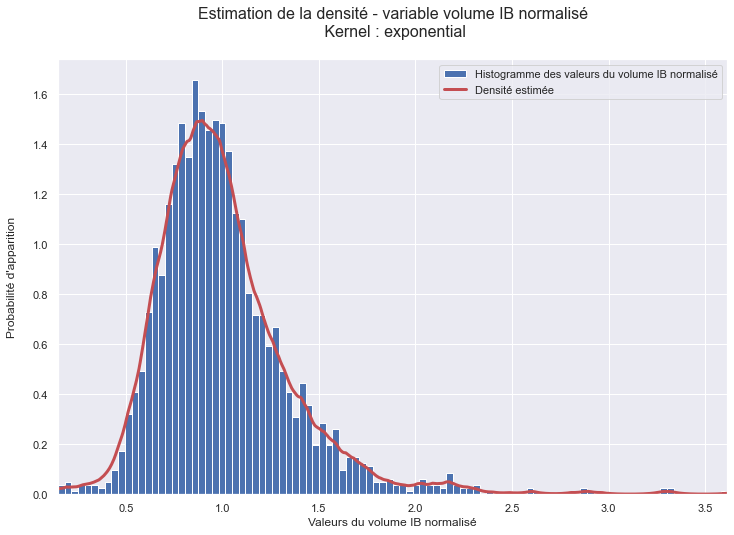

temps total : 2929.92 s


In [150]:
estim_volume_norm = estimate_density(volume_IB_norm)

#### 5 minutes

In [ ]:
estim_spread_norm = estimate_density(spread_norm)

In [ ]:
estim_volume_norm = estimate_density(volume_norm)

Cross-validation



# Recherche des quantiles

In [75]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)

def get_log_likelyhood(data, bandwidth, kernel):
    with tf.device('/device:GPU:0'):
        model = KernelDensity(bandwidth=bandwidth, kernel=kernel)

        sample = np.array(data).reshape((len(data), 1))
        model.fit(sample)

        log_likelyhood = model.score_samples
        return log_likelyhood

In [76]:
def get_density(x, log_likelyhood):
    z = np.array([x]).reshape(-1, 1)
    return np.exp(log_likelyhood(z))[0]

In [210]:
def compute_quantile(data, bandwidth, kernel, quantiles_sought):
    title = find_data_title(data)
    
    N = max(100000, int(len(data)*1.1))
    
    log_likelyhood = get_log_likelyhood(data, bandwidth, kernel)
    '''
    x = np.linspace(0.75*np.min(data), 1.25*np.max(data), N)
    y = [get_density(z, log_likelyhood) for z in x]
    
    y[0] = y[1]
    y = np.abs(y)

    values_found = []
    for quantile_sought in quantiles_sought:
        stop_integral = []

        # on intègre à chaque étape de 0 à un réel de plus en plus petit
        # à chaque itération, on stoppe si on descend en-dessous du quantile cherché
        for k in range(0, N):
            if k == 0:
                xx = x
                yy = y
            else:
                xx = x[0:-k]
                yy = y[0:-k]
            v = np.trapz(yy, xx)
            stop_integral.append(xx[-1])
            #print(f"Integral {k} from {xx[0]} to {xx[-1]} is equal to {v}")
            if v <= quantile_sought:
                break

        #print(f"\n\n quantile -> {stop_integral[-2]}")
        if len(stop_integral) >= 2:
            print(f"Valeur du quantile à {100*quantile_sought} % -> {round(stop_integral[-2], 6)}")
            values_found.append(stop_integral[-2])
        elif len(stop_integral) == 1:
            print(f"Valeur du quantile à {100*quantile_sought} % -> {round(stop_integral[0], 6)}")
            values_found.append(stop_integral[0])
        else:
            print(f"Valeur du quantile à {100*quantile_sought} % -> Haven't found it")
    '''
    #BS
    values_found = [566.373675, 1148.409528, 3323.372618, 13111.117858, 17917.5, 17917.5, 17917.5]
    #End BS
    
    # tracé de la fonction de densité, sur un espace plus restreint [-10, 10]
    #values = np.array(np.linspace(np.min(data), np.max(data), N))
    values = np.array(np.linspace(-1.5, np.max(data), N))
    values = values.reshape((len(values), 1))
    a = [get_density(z, log_likelyhood) for z in values]
    plt.figure(figsize=(10,6))
    plt.plot(values, a, 'r', label='densité')
    
    values_quantiles = [get_density(values_found[i], log_likelyhood) for i in range(len(values_found))]
    plt.scatter(values_found, values_quantiles, c = 'black', label='quantiles', marker='x')
    #for i in range(5):
        #plt.scatter(values_found[i], get_density(values_found[i], log_likelyhood), c = 'black', label='quantiles', marker='x')
    plt.title(f'Fonction densité: {title}\n')
    plt.legend(loc='best')
    plt.show()
    
    return values_found, values_quantiles

In [78]:
quantiles_sought = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]

## Daily

Valeur du quantile à 5.0 % -> 59.056766
Valeur du quantile à 10.0 % -> 73.54731
Valeur du quantile à 25.0 % -> 103.673012
Valeur du quantile à 50.0 % -> 149.032665
Valeur du quantile à 75.0 % -> 218.641561
Valeur du quantile à 90.0 % -> 305.691032
Valeur du quantile à 95.0 % -> 380.845983


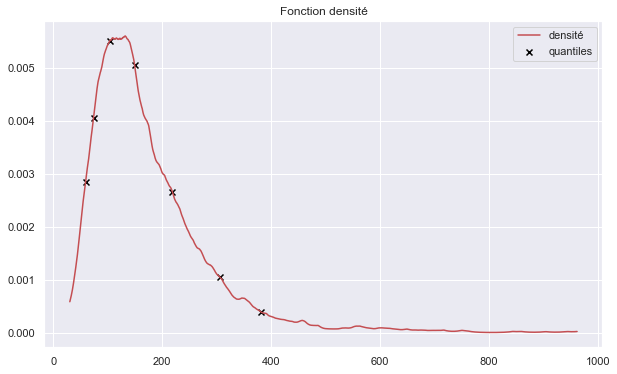

In [168]:
quantiles_spread_daily = compute_quantile(spread_daily, 12.9, 'exponential', quantiles_sought)

Valeur du quantile à 5.0 % -> -0.010251
Valeur du quantile à 10.0 % -> -0.00799
Valeur du quantile à 25.0 % -> -0.004518
Valeur du quantile à 50.0 % -> -0.00081
Valeur du quantile à 75.0 % -> 0.003678
Valeur du quantile à 90.0 % -> 0.009275
Valeur du quantile à 95.0 % -> 0.013842


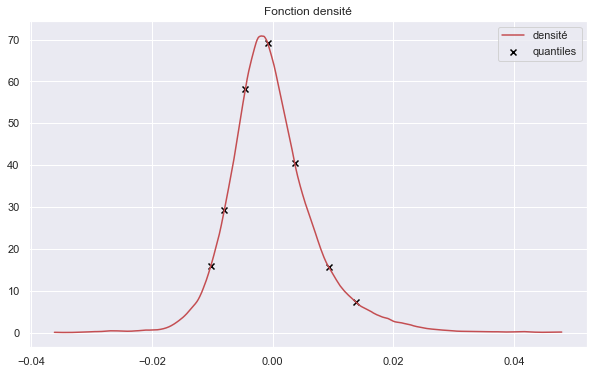

In [169]:
quantiles_spread_daily_norm = compute_quantile(spread_daily_norm, 0.002, 'exponential', quantiles_sought)

Valeur du quantile à 5.0 % -> 41456.774848
Valeur du quantile à 10.0 % -> 51057.255633
Valeur du quantile à 25.0 % -> 68539.047138
Valeur du quantile à 50.0 % -> 88695.781763
Valeur du quantile à 75.0 % -> 110556.418512
Valeur du quantile à 90.0 % -> 134221.72579
Valeur du quantile à 95.0 % -> 151193.568093


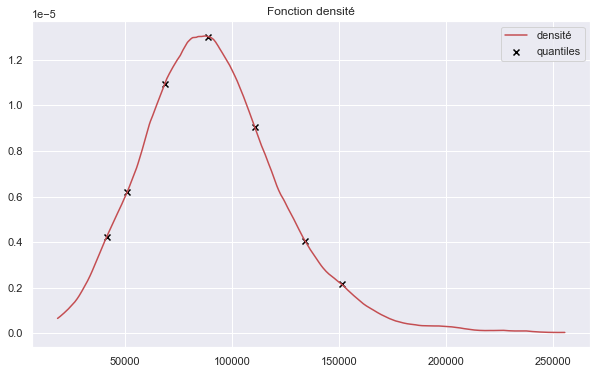

In [170]:
quantiles_volume_daily = compute_quantile(volume_daily, 8944.7, 'exponential', quantiles_sought)

Valeur du quantile à 5.0 % -> 0.60353
Valeur du quantile à 10.0 % -> 0.696013
Valeur du quantile à 25.0 % -> 0.826239
Valeur du quantile à 50.0 % -> 0.979289
Valeur du quantile à 75.0 % -> 1.157887
Valeur du quantile à 90.0 % -> 1.351459
Valeur du quantile à 95.0 % -> 1.50262


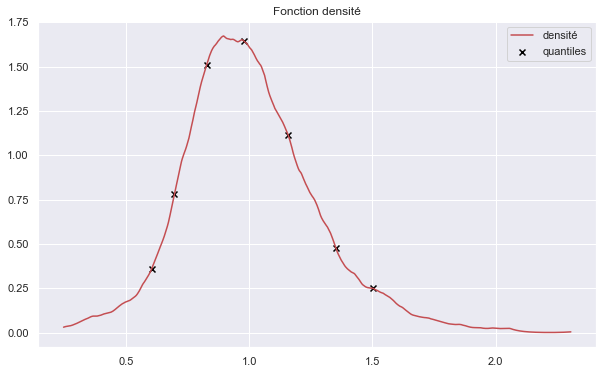

In [171]:
quantiles_volume_daily_norm = compute_quantile(volume_daily_norm, 0.045, 'exponential', quantiles_sought)

## Initial Balance

Valeur du quantile à 5.0 % -> 17.086956
Valeur du quantile à 10.0 % -> 21.669697
Valeur du quantile à 25.0 % -> 31.118186
Valeur du quantile à 50.0 % -> 44.861444
Valeur du quantile à 75.0 % -> 64.5429
Valeur du quantile à 90.0 % -> 93.03732
Valeur du quantile à 95.0 % -> 122.604191


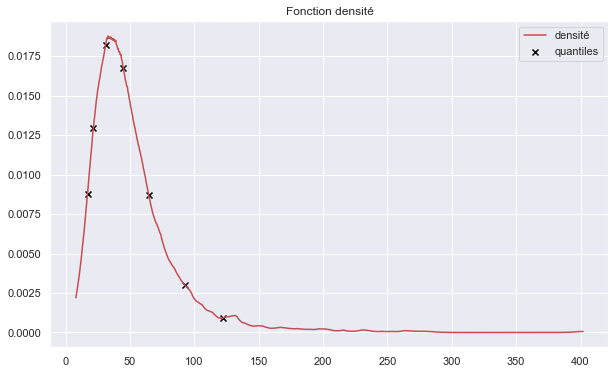

In [172]:
quantiles_spread_IB = compute_quantile(spread_IB, 4.9, 'exponential', quantiles_sought)

Valeur du quantile à 5.0 % -> -0.003598
Valeur du quantile à 10.0 % -> -0.002718
Valeur du quantile à 25.0 % -> -0.001468
Valeur du quantile à 50.0 % -> -0.000225
Valeur du quantile à 75.0 % -> 0.001228
Valeur du quantile à 90.0 % -> 0.003035
Valeur du quantile à 95.0 % -> 0.004443


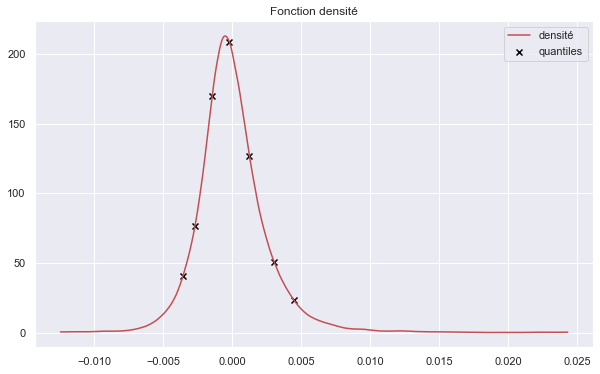

In [173]:
quantiles_spread_IB_norm = compute_quantile(spread_IB_norm, 0.001, 'exponential', quantiles_sought)

Valeur du quantile à 5.0 % -> 2722.765068
Valeur du quantile à 10.0 % -> 3297.738315
Valeur du quantile à 25.0 % -> 4304.53936
Valeur du quantile à 50.0 % -> 5581.574416
Valeur du quantile à 75.0 % -> 7125.427122
Valeur du quantile à 90.0 % -> 9156.79428
Valeur du quantile à 95.0 % -> 10778.881611


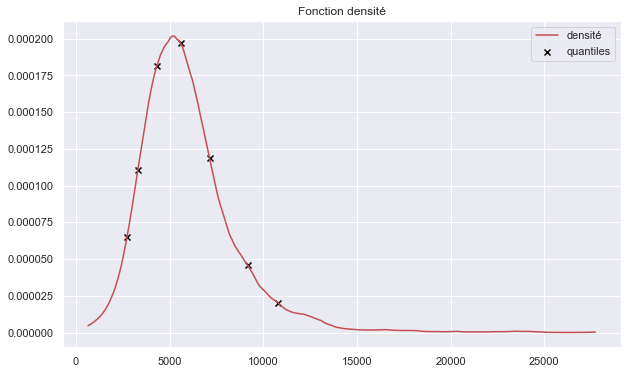

In [174]:
quantiles_volume_IB = compute_quantile(volume_IB, 596.9, 'exponential', quantiles_sought)

Valeur du quantile à 5.0 % -> 0.558604
Valeur du quantile à 10.0 % -> 0.63705
Valeur du quantile à 25.0 % -> 0.776138
Valeur du quantile à 50.0 % -> 0.949117
Valeur du quantile à 75.0 % -> 1.160658
Valeur du quantile à 90.0 % -> 1.429712
Valeur du quantile à 95.0 % -> 1.633188


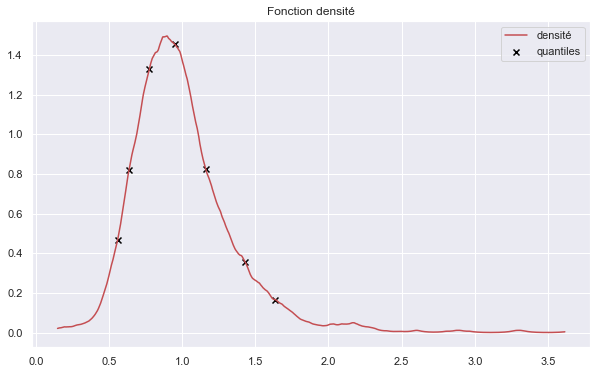

In [175]:
quantiles_volume_IB_norm = compute_quantile(volume_IB_norm, 0.051, 'exponential', quantiles_sought)

## 5 minutes

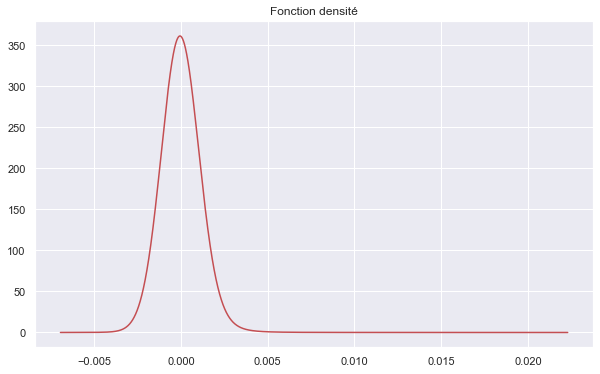

Valeur du quantile à 10.0 % -> -0.00143
Valeur du quantile à 25.0 % -> -0.000766
Valeur du quantile à 50.0 % -> -2.7e-05
Valeur du quantile à 75.0 % -> 0.000727
Valeur du quantile à 90.0 % -> 0.001437


In [112]:
quantiles_spread_norm = compute_quantile(spread_norm, 0.001, 'gaussian', quantiles_sought)

In [205]:
quantiles_volume = compute_quantile(volume, 5270, 'exponential', quantiles_sought)


KeyboardInterrupt



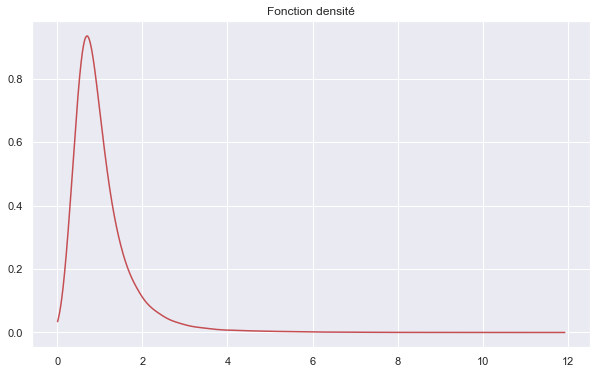

Valeur du quantile à 10.0 % -> 0.393155
Valeur du quantile à 25.0 % -> 0.592713
Valeur du quantile à 50.0 % -> 0.867726
Valeur du quantile à 75.0 % -> 1.267836
Valeur du quantile à 90.0 % -> 1.856548


In [113]:
quantiles_volume_norm = compute_quantile(volume_norm, 0.101, 'gaussian', quantiles_sought)

## Classer en fonction des quantiles

In [191]:
def classes(x, quantiles):
    q10 = quantiles[0]
    q25 = quantiles[1]
    q50 = quantiles[2]
    q75 = quantiles[3]
    q90 = quantiles[4]
    
    if x <= q10:
        return -2
    if q10 < x and x <= q25:
        return -1
    if x >= q90:
        return 2
    if q75 <= x and x < q90:
        return 1
    return 0

## Daily

In [192]:
classes_spread_daily = [classes(x, quantiles_spread_daily) for x in spread_daily]

In [193]:
classes_spread_daily_norm = [classes(x, quantiles_spread_daily_norm) for x in spread_daily_norm]

In [194]:
classes_volume_daily = [classes(x, quantiles_volume_daily) for x in volume_daily]

In [195]:
classes_volume_daily_norm = [classes(x, quantiles_volume_daily_norm) for x in volume_daily_norm]

## Initial Balance

In [196]:
classes_spread_IB = [classes(x, quantiles_spread_IB) for x in spread_IB]

In [197]:
classes_spread_IB_norm = [classes(x, quantiles_spread_IB_norm) for x in spread_IB_norm]

In [198]:
classes_volume_IB = [classes(x, quantiles_volume_IB) for x in volume_IB]

In [199]:
classes_volume_IB_norm = [classes(x, quantiles_volume_IB_norm) for x in volume_IB_norm]

## 5 minutes

In [141]:
classes_spread_norm = [classes(x, quantiles_spread_norm) for x in spread_norm]

In [142]:
classes_volume_norm = [classes(x, quantiles_volume_norm) for x in volume_norm]

## Save

In [143]:
classes_df = pd.DataFrame()

In [144]:
#classes_df['Spread'] = pd.Series(classes_spread)
#classes_df['Volume'] = pd.Series(classes_volume)

classes_df['Spread Daily'] = pd.Series(classes_spread_daily)
classes_df['Volume Daily'] = pd.Series(classes_volume_daily)

classes_df['Spread IB'] = pd.Series(classes_spread_IB)
classes_df['Volume IB'] = pd.Series(classes_volume_IB)

In [145]:
classes_df['Spread Norm'] = pd.Series(classes_spread_norm)
classes_df['Volume Norm'] = pd.Series(classes_volume_norm)

classes_df['Spread Daily Norm'] = pd.Series(classes_spread_daily_norm)
classes_df['Volume Daily Norm'] = pd.Series(classes_volume_daily_norm)

classes_df['Spread IB Norm'] = pd.Series(classes_spread_IB_norm)
classes_df['Volume IB Norm'] = pd.Series(classes_volume_IB_norm)

In [147]:
classes_df.to_csv("./Data/Classes_zscore_estim", sep = ';', index=False)

## Visualization

## Classification Z-score

In [79]:
def moyenne_mobile_k(k,n, liste, profondeur):
    if k<profondeur:
        sum_= 0
        for i in range(k+1):
            sum_ += liste[i]**n
        return sum_/(k+1)
    else:
        sum_ = 0
        for i in range(k, k-profondeur, -1):
            sum_ += liste[i]**n
        return sum_/profondeur
    
def variance_mobile(k, liste, moyenneMob, profondeur):
    return moyenne_mobile_k(k,2, liste, profondeur)-(moyenneMob[k])**2

def moyenne_mobile(data, profondeur):
    return [moyenne_mobile_k(k, 1, data, profondeur) for k in range(len(data))]

def ecartType_mobile(data, moyMob, profondeur):
    return [(variance_mobile(k, data, moyMob, profondeur))**0.5 for k in range(len(data))]

In [98]:
def classes_extremes(data, x, quantiles):
    q05 = quantiles[0]
    q10 = quantiles[1]
    q25 = quantiles[2]
    q50 = quantiles[3]
    q75 = quantiles[4]
    q90 = quantiles[5]
    q95 = quantiles[6]
    
    if x <= q05:
        return -3
    if x >= q95:
        return 3
    
    return 0

In [149]:
def modalite_3classes(data, k, a1, moy, ecart):
    if data[k] < moy[k] - a1*ecart[k]:
        return -1
    if data[k] > moy[k] + a1*ecart[k]:
        return 1
    return 0

def modalite_4classes(data, k, a1, a2, moy, ecart):
    if data[k] < moy[k] - a1*ecart[k]:
        return -1
    if data[k] > moy[k] + a2*ecart[k]:
        return 1
    return 0

def modalite(data, k, a1, a2, b1, b2, moy, ecart):
    x = data[k]
    if data[k] <= moy[k] - a2*ecart[k]:
        return -2
    if moy[k] - a2*ecart[k] < x and x <= moy[k] - a1*ecart[k]:
        return -1
    
    if x >= moy[k] + b2*ecart[k]:
        return 2
    if moy[k] + b1*ecart[k] <= x and x < moy[k] + b2*ecart[k]:
        return 1
    
    return 0

In [109]:
def classifier_extremes_zscore_3classes(data, quantiles, a1, moy, ecart):
    classification = [classes_extremes(data, x, quantiles) for x in data]
    for k in range(len(data)):
        if classification[k] == 0: #otherwise, extreme value hence already classified
            classification[k] = modalite_3classes(data, k, a1, moy, ecart)
            
    return classification

def classifier_extremes_zscore_4classes(data, quantiles, a1, a2, moy, ecart):
    classification = [classes_extremes(data, x, quantiles) for x in data]
    for k in range(len(data)):
        if classification[k] == 0: #otherwise, extreme value hence already classified
            classification[k] = modalite_4classes(data, k, a1, a2, moy, ecart)
            
    return classification

def classifier_extremes_zscore(data, quantiles, a1, a2, b1, b2, moy, ecart):
    classification = [classes_extremes(data, x, quantiles) for x in data]
    for k in range(len(data)):
        if classification[k] == 0: #otherwise, extreme value hence already classified
            classification[k] = modalite(data, k, a1, a2, b1, b2, moy, ecart)
            
    return classification

In [110]:
def count_modalites_3classes(data, quantiles, a1, moy, ecart):
    modalites = classifier_extremes_zscore_3classes(data, quantiles, a1, moy, ecart)
    counts = [modalites.count(i)/len(data) for i in range(-3, 4)]
    return counts

def count_modalites_4classes(data, quantiles, a1, a2, moy, ecart):
    modalites = classifier_extremes_zscore_4classes(data, quantiles, a1, a2, moy, ecart)
    counts = [modalites.count(i)/len(data) for i in range(-3, 4)]
    return counts

def count_modalites(data, quantiles, a1, a2, b1, b2, moy, ecart):
    modalites = classifier_extremes_zscore(data, quantiles, a1, a2, b1, b2, moy, ecart)
    counts = [modalites.count(i)/len(data) for i in range(-3, 4)]
    return counts

In [102]:
def max_coeff_a1(data, min_a1, max_a1, quantiles, valeurs_quantiles, moy, ecart):
    val_q_pct = [x*len(data) for x in valeurs_quantiles]
    valeur_recherchee = val_q_pct[2] / (val_q_pct[2] + val_q_pct[3] + val_q_pct[4])
    
    opt_a1 = 0
    minDistance = 1000000000000 # just to make sure that it's superior to the max distance possible
    for a1 in np.arange(min_a1, max_a1, 0.01):
        #print(f"number searched: {len(np.arange(min_a1, a1, 0.01))}, nb total to search -> {len(np.arange(min_a1, max_a1, 0.01))}")
              
        counts = count_modalites_3classes(data, quantiles, a1, moy, ecart)
        if abs(counts[2] - valeur_recherchee) <= minDistance:
            minDistance = abs(counts[1] - valeur_recherchee)
            opt_a1 = a1
    return opt_a1

def max_coeff_a2(data, a1, min_a2, max_a2, quantiles, valeurs_quantiles, moy, ecart):
    val_q_pct = [x*len(data) for x in valeurs_quantiles]
    valeur_recherchee = val_q_pct[3] / (val_q_pct[2] + val_q_pct[3] + val_q_pct[4])
    
    opt_a2 = 0
    minDistance = 1000000000000 # just to make sure that it's superior to the max distance possible
    for a2 in np.arange(min_a2, max_a2, 0.01):
        #print(f"number searched: {len(np.arange(min_a2, a2, 0.01))}, nb total to search -> {len(np.arange(min_a2, max_a2, 0.01))}")
              
        counts = count_modalites_4classes(data, quantiles, a1, a2, moy, ecart)
        if abs(counts[3] - valeur_recherchee) <= minDistance:
            minDistance = abs(counts[3] - valeur_recherchee)
            opt_a2 = a2
    return opt_a2

def best_coeff(data, min_a1, max_a1, min_a2, max_a2, quantiles, valeurs_quantiles, moy, ecart):
    opt_a1 = max_coeff_a1(data, min_a1, max_a1, quantiles, valeurs_quantiles, moy, ecart)
    opt_a2 = max_coeff_a2(data, opt_a1, min_a2, max_a2, quantiles, valeurs_quantiles, moy, ecart)
    
    return opt_a1, opt_a2

In [174]:
def score(data, counts, valeurs_quantiles):
    val_q_pct = [x*len(data) for x in valeurs_quantiles]
    sum_ = val_q_pct[1] + val_q_pct[2] + val_q_pct[3] + val_q_pct[4] + val_q_pct[5]
    
    valeurs_recherchees = [val_q_pct[i] / sum_ for i in range(1, 6)]
    
    score = 0
    for i in range(len(valeurs_recherchees)):
        v = valeurs_recherchees[i]
        score += abs(v - counts[i+1])
    return score

In [181]:
def best_coeff(data, quantiles, valeurs_quantiles, moy, ecart):
    bestScore = float('inf')
    opt_a1, opt_a2, opt_b1, opt_b2 = 0, 0, 0, 0
    
    for a1 in np.arange(0.1, 1.1, 0.1):
        for a2 in np.arange(a1+0.1, 2.1, 0.1):
            for b1 in np.arange(0.1, 1.1, 0.1):
                for b2 in np.arange(b1+0.1, 2.1, 0.1):
                    classif = classifier_extremes_zscore(data, quantiles, a1, a2, b1, b2, moy, ecart)
                    counts = count_modalites(data, quantiles, a1, a2, b1, b2, moy, ecart)
                    score_ = score(data, counts, valeurs_quantiles)
                    #print(f"a1 -> {a1}, a2 -> {a2}, b1 -> {b1}, b2 -> {b2}")
                    #print(f" score -> {score_} / best score -> {bestScore}")
                    if score_ < bestScore:
                        bestScore = score_
                        opt_a1, opt_a2, opt_b1, opt_b2 = a1, a2, b1, b2
                        
    return opt_a1, opt_a2, opt_b1, opt_b2

In [176]:
def opt_classif(data, quantiles, valeurs_quantiles, moy, ecart):
    a1, a2, b1, b2 = best_coeff(data, quantiles, valeurs_quantiles, moy, ecart)
    print(f"a1 -> {round(a1, 3)}, a2 -> {round(a2, 3)}, b1 -> {round(b1, 3)}, b2 -> {round(b2, 3)}\n")
    
    title = find_data_title(data)
    type_data = title.split(" ")[0]
    intervalle = title.split(" ")[1]
    normalise = ""
    if len(title.split(" ")) > 2:
        normalise += " - normalisé"
    classif = classifier_extremes_zscore(data, quantiles, a1, a2, b1, b2, moy, ecart)
    
    plt.figure(figsize=(10,7))
    labels, counts = np.unique(classif, return_counts=True)
    counts = counts / len(classif)
    plt.bar(labels, counts, align='center', color = 'black')
    plt.gca().set_xticks(labels)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.title('Zscore ' + str(type_data) + " - " + str(intervalle) + str(normalise) + "\n", fontsize=17)
    plt.ylabel('Pourcentage')
    plt.xlabel('Modalité')
    plt.show()
    
    return classif

# 

# 

# 

# 

# Do everything at once

In [208]:
quantiles_sought = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]

In [183]:
import time
def do_all(data, bandwidth, kernel):
    start = time.time()

    '''
    quantiles = [566.373675, 1148.409528, 3323.372618, 13111.117858, 17917.5, 17917.5, 17917.5]
    log_likelyhood = get_log_likelyhood(data, bandwidth, kernel)
    values_quantiles = [get_density(quantiles[i], log_likelyhood) for i in range(len(quantile))]
    '''
    
    quantiles, valeurs_quantiles = compute_quantile(data, bandwidth, kernel, quantiles_sought)
    
    depth = 14
    moy = moyenne_mobile(data, depth)
    ecart = ecartType_mobile(data, moy, depth)
    
    classif = opt_classif(data, quantiles, valeurs_quantiles, moy, ecart)
    
    stop = time.time()
    total = round(stop - start, 2)
    print("temps total : " + str(total) + " s")
    if total > 60:
        print(f"temps total : {total//60} min {round(total%60, 2)} s")
    
    return classif

## Daily

Valeur du quantile à 5.0 % -> 59.056766
Valeur du quantile à 10.0 % -> 73.54731
Valeur du quantile à 25.0 % -> 103.673012
Valeur du quantile à 50.0 % -> 149.032665
Valeur du quantile à 75.0 % -> 218.641561
Valeur du quantile à 90.0 % -> 305.691032
Valeur du quantile à 95.0 % -> 380.845983


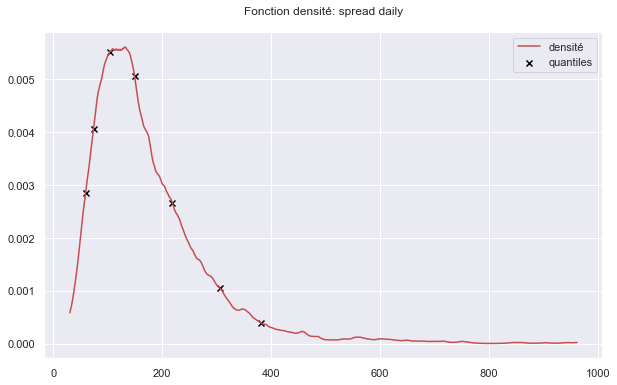

a1 -> 0.1, a2 -> 0.8, b1 -> 0.8, b2 -> 2.1



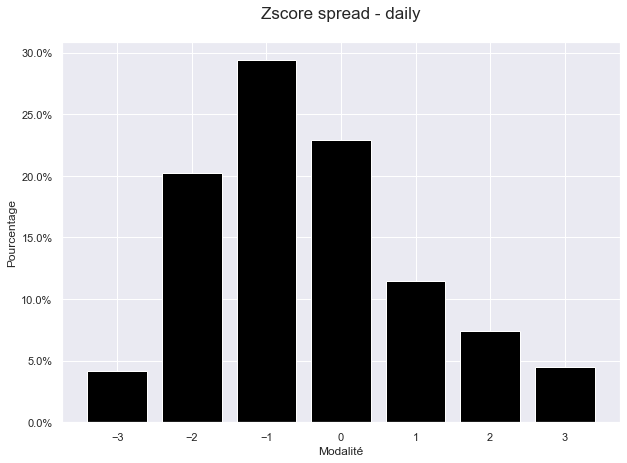

temps total : 1455.68 s
temps total : 24.0 min 15.68 s


In [184]:
classif_spread_daily = do_all(spread_daily, 12.9, 'exponential')

Valeur du quantile à 5.0 % -> -0.010251
Valeur du quantile à 10.0 % -> -0.00799
Valeur du quantile à 25.0 % -> -0.004518
Valeur du quantile à 50.0 % -> -0.00081
Valeur du quantile à 75.0 % -> 0.003678
Valeur du quantile à 90.0 % -> 0.009275
Valeur du quantile à 95.0 % -> 0.013842


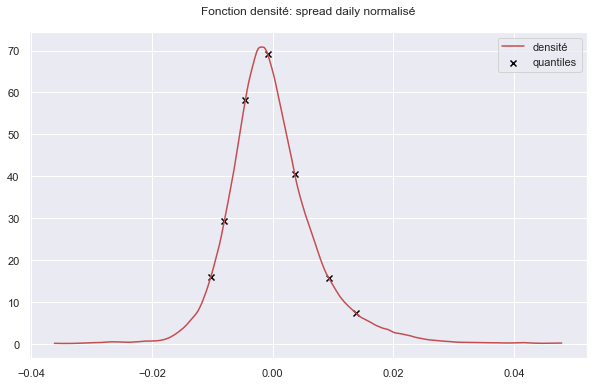

a1 -> 0.4, a2 -> 1.2, b1 -> 0.5, b2 -> 1.9



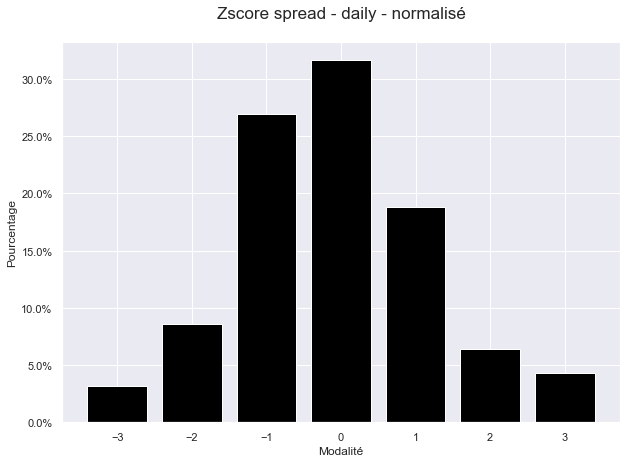

temps total : 338.12 s
temps total : 5.0 min 38.12 s


In [185]:
classif_spread_daily_norm = do_all(spread_daily_norm, 0.002, 'exponential')

Valeur du quantile à 5.0 % -> 41456.774848
Valeur du quantile à 10.0 % -> 51057.255633
Valeur du quantile à 25.0 % -> 68539.047138
Valeur du quantile à 50.0 % -> 88695.781763
Valeur du quantile à 75.0 % -> 110556.418512
Valeur du quantile à 90.0 % -> 134221.72579
Valeur du quantile à 95.0 % -> 151193.568093


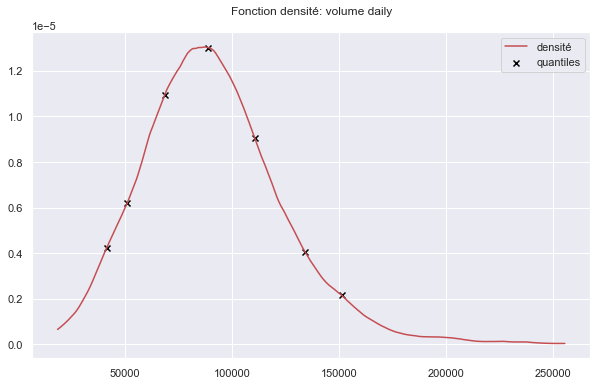

a1 -> 0.4, a2 -> 1.2, b1 -> 0.5, b2 -> 1.6



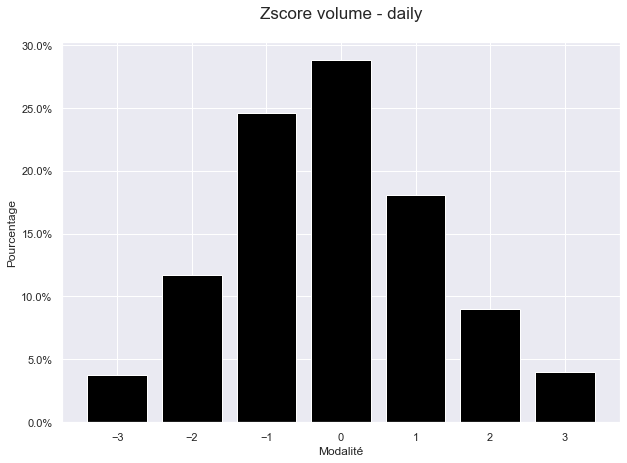

temps total : 1406.07 s
temps total : 23.0 min 26.07 s


In [186]:
classif_volume_daily = do_all(volume_daily, 8944.7, 'exponential')

Valeur du quantile à 5.0 % -> 0.60353
Valeur du quantile à 10.0 % -> 0.696013
Valeur du quantile à 25.0 % -> 0.826239
Valeur du quantile à 50.0 % -> 0.979289
Valeur du quantile à 75.0 % -> 1.157887
Valeur du quantile à 90.0 % -> 1.351459
Valeur du quantile à 95.0 % -> 1.50262


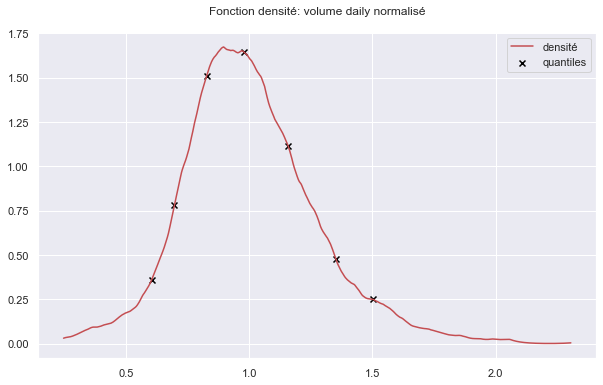

a1 -> 0.2, a2 -> 1.0, b1 -> 0.6, b2 -> 1.5



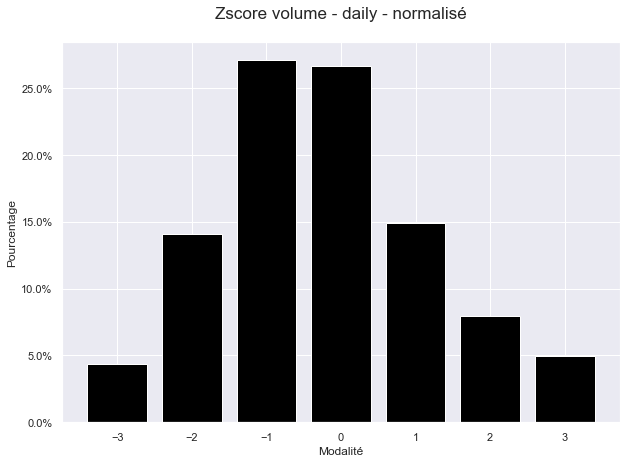

temps total : 329.61 s
temps total : 5.0 min 29.61 s


In [187]:
classif_volume_daily_norm = do_all(volume_daily_norm, 0.045, 'exponential')

## Initial Balance

Valeur du quantile à 5.0 % -> 17.086956
Valeur du quantile à 10.0 % -> 21.669697
Valeur du quantile à 25.0 % -> 31.118186
Valeur du quantile à 50.0 % -> 44.861444
Valeur du quantile à 75.0 % -> 64.5429
Valeur du quantile à 90.0 % -> 93.03732
Valeur du quantile à 95.0 % -> 122.604191


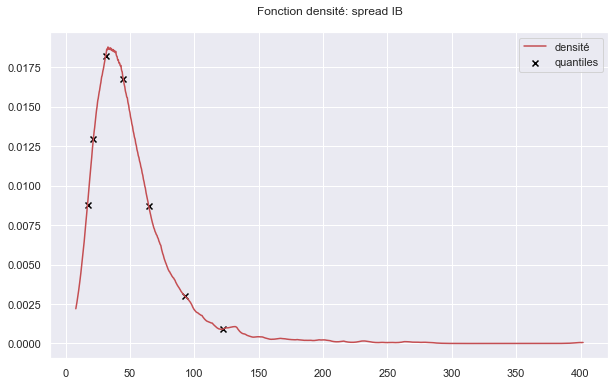

a1 -> 0.2, a2 -> 0.9, b1 -> 0.8, b2 -> 2.1



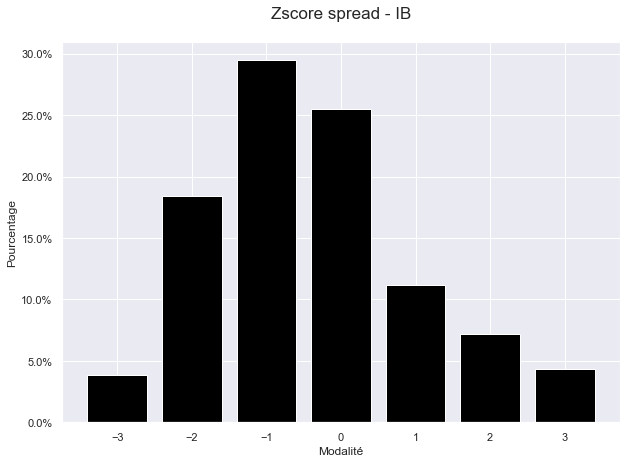

temps total : 332.16 s
temps total : 5.0 min 32.16 s


In [188]:
classif_spread_IB = do_all(spread_IB, 4.9, 'exponential')

Valeur du quantile à 5.0 % -> -0.003598
Valeur du quantile à 10.0 % -> -0.002718
Valeur du quantile à 25.0 % -> -0.001468
Valeur du quantile à 50.0 % -> -0.000225
Valeur du quantile à 75.0 % -> 0.001228
Valeur du quantile à 90.0 % -> 0.003035
Valeur du quantile à 95.0 % -> 0.004443


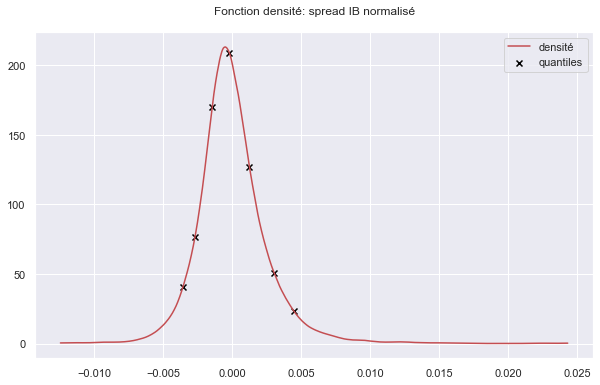

a1 -> 0.4, a2 -> 1.1, b1 -> 0.5, b2 -> 1.8



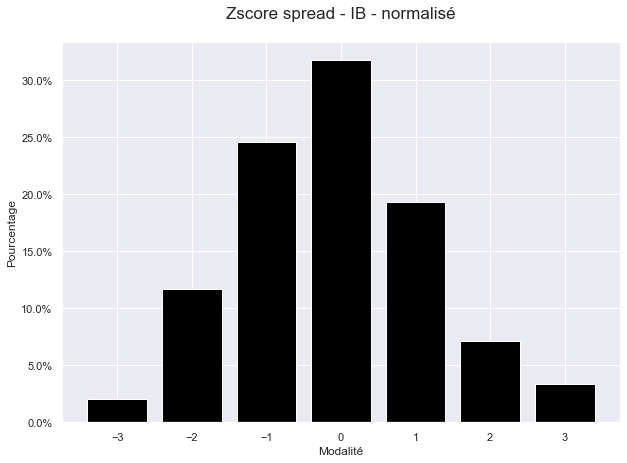

temps total : 340.7 s
temps total : 5.0 min 40.7 s


In [189]:
classif_spread_IB_norm = do_all(spread_IB_norm, 0.001, 'exponential')

Valeur du quantile à 5.0 % -> 2722.765068
Valeur du quantile à 10.0 % -> 3297.738315
Valeur du quantile à 25.0 % -> 4304.53936
Valeur du quantile à 50.0 % -> 5581.574416
Valeur du quantile à 75.0 % -> 7125.427122
Valeur du quantile à 90.0 % -> 9156.79428
Valeur du quantile à 95.0 % -> 10778.881611


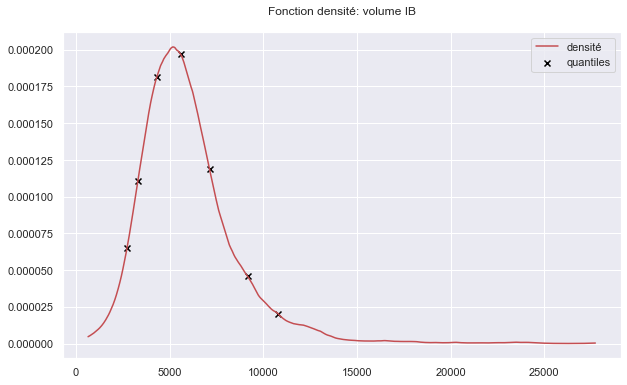

a1 -> 0.4, a2 -> 1.0, b1 -> 0.4, b2 -> 1.8



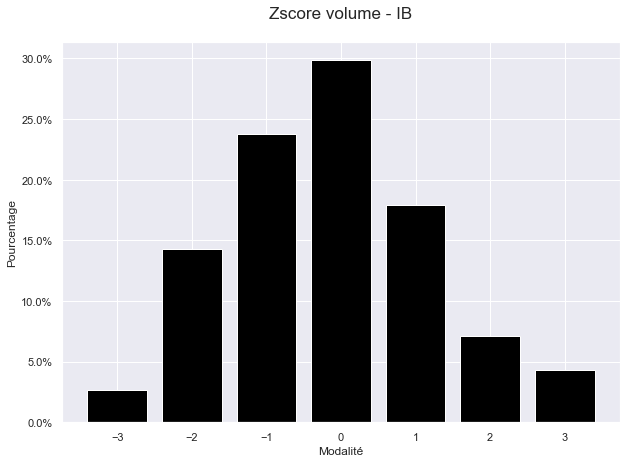

temps total : 339.4 s
temps total : 5.0 min 39.4 s


In [190]:
classif_volume_IB = do_all(volume_IB, 596.9, 'exponential')

Valeur du quantile à 5.0 % -> 0.558604
Valeur du quantile à 10.0 % -> 0.63705
Valeur du quantile à 25.0 % -> 0.776138
Valeur du quantile à 50.0 % -> 0.949117
Valeur du quantile à 75.0 % -> 1.160658
Valeur du quantile à 90.0 % -> 1.429712
Valeur du quantile à 95.0 % -> 1.633188


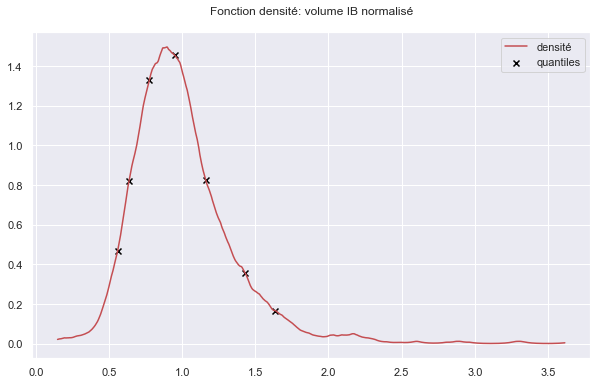

a1 -> 0.3, a2 -> 0.9, b1 -> 0.6, b2 -> 1.8



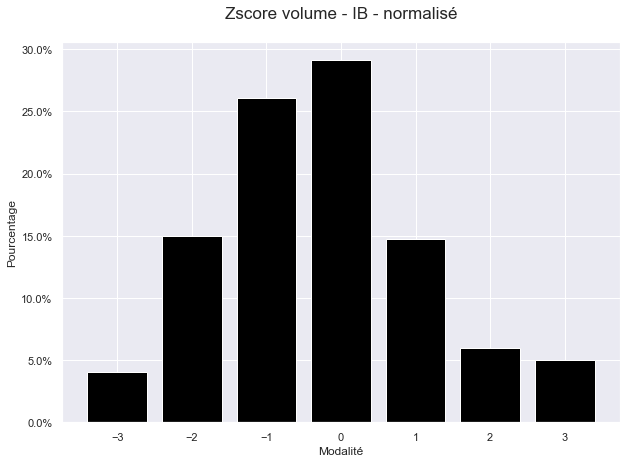

temps total : 358.74 s
temps total : 5.0 min 58.74 s


In [191]:
classif_volume_IB_norm = do_all(volume_IB_norm, 0.051, 'exponential')

## 5 minutes

Valeur du quantile à 5.0 % -> 18.665842
Valeur du quantile à 10.0 % -> 22.454175
Valeur du quantile à 25.0 % -> 31.257208
Valeur du quantile à 50.0 % -> 43.868434
Valeur du quantile à 75.0 % -> 62.661147
Valeur du quantile à 90.0 % -> 89.750458
Valeur du quantile à 95.0 % -> 114.094096


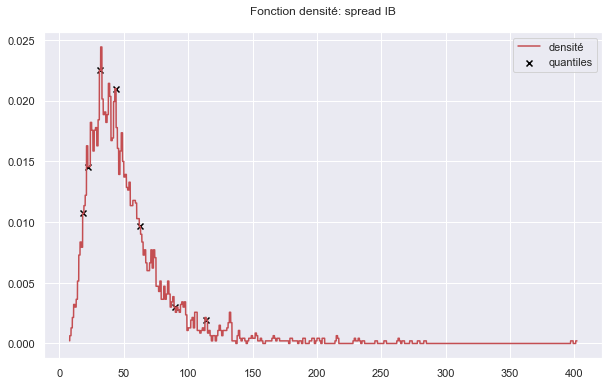

a1 -> 0.2, a2 -> 0.9, b1 -> 0.8, b2 -> 2.1



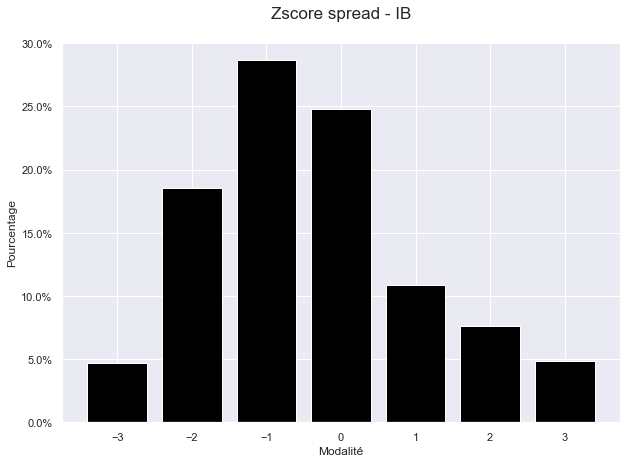

temps total : 389.97 s
temps total : 6.0 min 29.97 s


In [196]:
classif_spread = do_all(spread_IB, 1, 'tophat')

Valeur du quantile à 5.0 % -> -0.001831
Valeur du quantile à 10.0 % -> -0.00143
Valeur du quantile à 25.0 % -> -0.000766
Valeur du quantile à 50.0 % -> -2.7e-05
Valeur du quantile à 75.0 % -> 0.000727
Valeur du quantile à 90.0 % -> 0.001437
Valeur du quantile à 95.0 % -> 0.001893


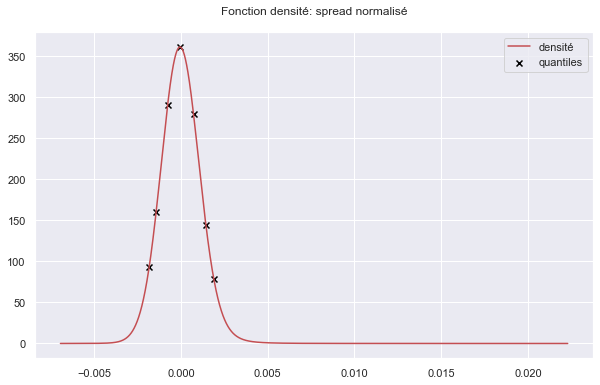

a1 -> 0.4, a2 -> 1.0, b1 -> 0.3, b2 -> 1.4



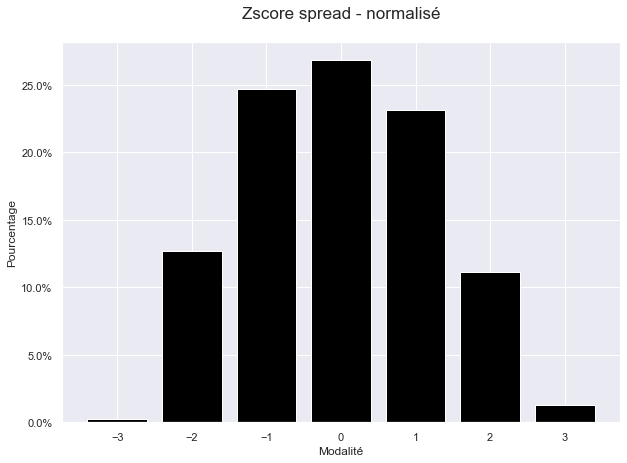

temps total : 82323.92 s
temps total : 1372.0 min 3.92 s


In [192]:
classif_spread_norm = do_all(spread_norm, 0.001, 'gaussian')

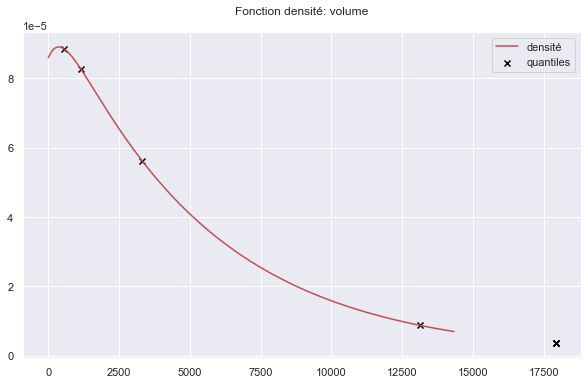

In [ ]:
classif_volume = do_all(volume, 5270, 'exponential')

Valeur du quantile à 5.0 % -> 0.28949
Valeur du quantile à 10.0 % -> 0.393155
Valeur du quantile à 25.0 % -> 0.592713
Valeur du quantile à 50.0 % -> 0.867726
Valeur du quantile à 75.0 % -> 1.267836
Valeur du quantile à 90.0 % -> 1.856548
Valeur du quantile à 95.0 % -> 2.385828


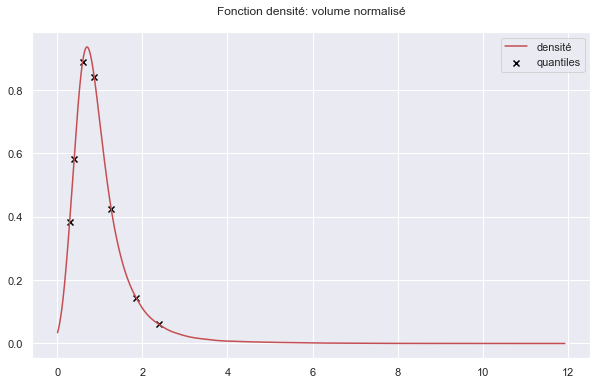

a1 -> 0.3, a2 -> 1.0, b1 -> 0.8, b2 -> 2.1



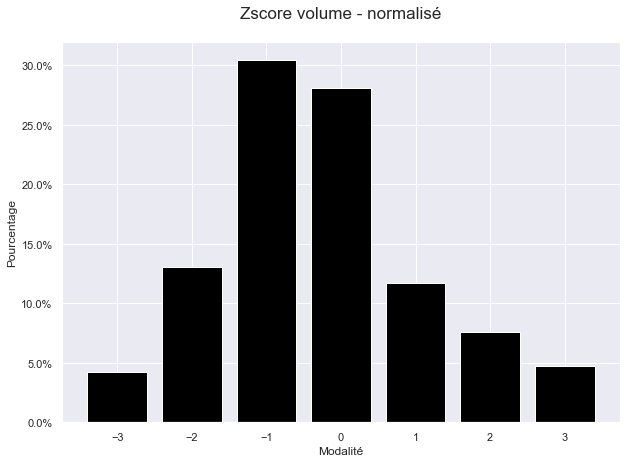

temps total : 61661.56 s
temps total : 1027.0 min 41.56 s


In [193]:
classif_volume_norm = do_all(volume_norm, 0.101, 'gaussian')